In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# federated learning model

In [14]:
# load the kaggle data and extract the input and output
data = pd.read_csv('./data/train.csv')
features = ['LotArea']
target = 'SalePrice'
X = data[features].values
Y = data[target].values
# split the data set into training and testing data (if needed)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# convert everything to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)
# define a simple regression network
class GlobalModel(nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        self.linear = nn.Linear(1, 1)
    def forward(self, x):
        return self.linear(x)
# number of clients
clients = 10
# sample size
samplesClient = 50
# federated learning parameters
rounds = 60
localEpochs = 10
lossValues = []
globalModel = GlobalModel()
percentages = []
localModels = []
for rnd in range(rounds):
    print(f"Starting round {rnd + 1}")
    for client in range(clients):
        localLosses = []  # Initialize localLosses for each client
        # load the client's data
        i = client * samplesClient
        j = i + samplesClient
        X_train_client = X_train[i:j]
        y_train_client = Y_train[i:j]
        # create a local model and optimizer and loss for each client
        localModel = GlobalModel()
        localModel.load_state_dict(globalModel.state_dict())
        optimizer = optim.SGD(localModel.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        # start training on local model
        for epoch in range(localEpochs):
            localModel.train()
            optimizer.zero_grad()
            outputs = localModel(X_train_client)
            loss = criterion(outputs, y_train_client)
            loss.backward()
            optimizer.step()
            localLosses.append(loss.item())
            averagedTrainingLoss = sum(localLosses) / len(localLosses)
            print(f"Client {client + 1} has trained for {epoch + 1}/{localEpochs} epochs with a loss: {loss.item()}")
        lossValues.append(averagedTrainingLoss)
        localModels.append(localModel)
    # model aggregation
    with torch.no_grad():
        for global_param, local_params in zip(globalModel.parameters(), zip(*[local_model.parameters() for local_model in localModels])):
            global_param.data = torch.stack(local_params).mean(dim=0)
    # calculate the average loss
    finalTrainLoss = sum(lossValues) / len(lossValues)
    lossValues.append(finalTrainLoss)
    # Calculate the percentage loss
    with torch.no_grad():
        globalModel.eval()
        outputs = globalModel(X_train)
        percentageValues = (torch.abs(outputs - Y_train) / Y_train).mean().item() * 100
        percentages.append(percentageValues)
    print(f"Global Model, Round {rnd + 1}, Train Loss: {percentageValues:.2f}%")

Starting round 1
Client 1 has trained for 1/10 epochs with a loss: 37636308992.0
Client 1 has trained for 2/10 epochs with a loss: 36428587008.0
Client 1 has trained for 3/10 epochs with a loss: 35268775936.0
Client 1 has trained for 4/10 epochs with a loss: 34154964992.0
Client 1 has trained for 5/10 epochs with a loss: 33085315072.0
Client 1 has trained for 6/10 epochs with a loss: 32058066944.0
Client 1 has trained for 7/10 epochs with a loss: 31071522816.0
Client 1 has trained for 8/10 epochs with a loss: 30124056576.0
Client 1 has trained for 9/10 epochs with a loss: 29214121984.0
Client 1 has trained for 10/10 epochs with a loss: 28340201472.0
Client 2 has trained for 1/10 epochs with a loss: 34264104960.0
Client 2 has trained for 2/10 epochs with a loss: 33070577664.0
Client 2 has trained for 3/10 epochs with a loss: 31924963328.0
Client 2 has trained for 4/10 epochs with a loss: 30825334784.0
Client 2 has trained for 5/10 epochs with a loss: 29769842688.0
Client 2 has trained f

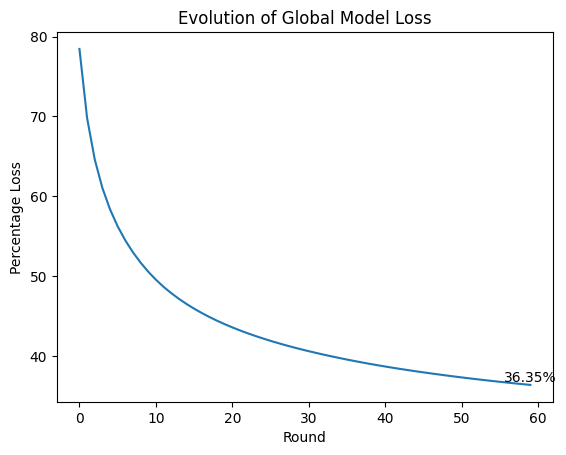

In [15]:
# plot
plt.plot(percentages)  # Update the plot with the new list
plt.xlabel('Round')
plt.ylabel('Percentage Loss')
plt.title('Evolution of Global Model Loss')
last_value = percentages[-1]
plt.text(len(percentages) - 1, last_value, f'{last_value:.2f}%', ha='center', va='bottom')
plt.show()